In [50]:
from pytket.circuit import Circuit, fresh_symbol
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.quantinuum import QuantinuumBackend
import matplotlib.pyplot as pl
from pytket.qasm import circuit_from_qasm_str

import os
print(os.getcwd())

from pytket.extensions.qiskit import qiskit_to_tk, AerBackend, AerStateBackend
from pytket.backends.backendresult import BackendResult
import pytket 
import qiskit as qk
from qiskit.providers.aer import AerSimulator
import pickle
import pandas as pd
import numpy as np

/Users/utkarshagrawal/Documents/Postdoc/U_1_exp/Quantinum/Weak measurements


In [5]:
def load_file(L,depth,p,Q,file_loc):
    
    with open (file_loc,'rb') as f:
        circ_q = pickle.load(f)
    return circ_q


In [6]:
def tket_circuit(L,depth,p,Q,file_loc):
    circ_q = load_file(L,depth,p,Q,file_loc)
    # new_circ = remove_save_statevector(circ_q['circuit'])
    # openqasm = circ_q['circuit'].qasm()
    # circ_p = circuit_from_qasm_str(openqasm)
    circ_p = qiskit_to_tk(circ_q['circuit'])
    # render_circuit_jupyter(circ_p)

    return circ_p, circ_q['circuit']

In [5]:
def get_L(filename):
    temp = filename[2:4]
    if '_' in temp:
        temp = temp[:-1]
    return int(temp)
    
def get_Q(filename):
    index = filename.index('Q')
    temp = filename[index+2:index+4]
    if '_' in temp:
        temp = temp[:-1]
    return int(temp)

def get_p(filename):
    index = filename.index('p=')
    temp = filename[index+2:index+7]
    while '_' in temp:
        temp = temp[:-1]
    return float(temp)


In [6]:
backend = AerBackend()


In [27]:
file_dir =  "../../Weak measurements/data/circ_data/special_scrambling/basis_gate_set=1/"
results = {}
# p_list = [0.624,0.677,0.73,0.783,0.836]
simulator = AerSimulator()
for file in os.listdir(file_dir):
    L = get_L(file)
    p = get_p(file)
    Q = get_Q(file)
    depth = L
    file_loc = file_dir + file
    if L not in [6,10]:
        continue
    # if p not in p_list:
    #     continue
    temp, temp_q = tket_circuit(L=L,depth=L,p=p,Q=Q,file_loc=file_loc)
    # temp = backend.get_compiled_circuit(temp)
    # handle = backend.process_circuit(temp, n_shots=200)
    # results[(L,depth,p,Q)] = backend.get_result(handle)

    job = simulator.run(temp_q,shots=200)
    results[(L,depth,p,Q)] = job.result()


file_dir =  "../../Weak measurements/data/multiple_ancilla/circ_data/special_scrambling/basis_gate_set=1/"
results_multiple = {}
# p_list = [0.624,0.677,0.73,0.783,0.836]
simulator = AerSimulator()
for file in os.listdir(file_dir):
    L = get_L(file)
    p = get_p(file)
    Q = get_Q(file)
    depth = L
    file_loc = file_dir + file
    if L not in [6,10]:
        continue
    # if p not in p_list:
    #     continue
    temp, temp_q = tket_circuit(L=L,depth=L,p=p,Q=Q,file_loc=file_loc)
    # temp = backend.get_compiled_circuit(temp)
    # handle = backend.process_circuit(temp, n_shots=200)
    # results_multiple[(L,depth,p,Q)] = backend.get_result(handle)

    job = simulator.run(temp_q,shots=200)
    results_multiple[(L,depth,p,Q)] = job.result()

## Analyze results

In [28]:
def outcome_results(result,L,depth):
    def get_bitlist():
        c_bits = [pytket.Bit('') for _ in range(L*depth)]
        for i in range(L*depth):
            x = i%L
            t = i//L
            temp = ['c'+str(t),[x]]
            c_bits[i] = c_bits[i].from_list(temp)
        return c_bits

    bitlist = get_bitlist()
    measurement_dic = result.get_counts(cbits=bitlist)
    # measurement_dic = {measurements in a shot:number of occurances}

    outcome_list = []

    for data,N in measurement_dic.items(): # data is measurement outcome in a shot
        # data = list(reversed(data)) 
        # we are reversing the data because quantinuum backend gives result in decending order of time. Whereas the sep_decoder takes input in ascending order
        data = np.array(data,dtype=int).reshape((depth,L))
        data = 2*data - 1
        outcome_list.append((data,N))

    return outcome_list


def outcome_history_qiskit(circuit_results,L,depth,p_locations):
    outcomes = list(circuit_results.get_counts().items())
    measurement_data = []
    for outcome_str, count in outcomes:
        outcome_str = list(reversed(outcome_str))
        outcome_list = []
        for s in outcome_str[:]:
            if not outcome_list:
                outcome_list.append([])
            if s != ' ':
                outcome_list[-1].append(2*int(s)-1)
            else:
                outcome_list.append([])
        # print(outcome_str,'\n',outcome_list)
    #     print(p_locations, results.get_counts(circ))
        
        measurement_array = np.zeros((depth,L))

        for t in range(depth):
            if t < depth - 1:
                loc = np.where(p_locations[t])[0]
            else:
                loc = range(0,L,1)
            # print(loc,outcome_list[t])
            measurement_array[t,loc] = [outcome_list[t][i] for i in loc]
        measurement_data.append((measurement_array,count))
        
    return measurement_data

In [29]:
# Already collected data. Don't run again!

## Get outcome data from the quantinuum emulator results

noisy_label = ''
# filedir = 'data/tket_simulation/tket_data/measurement_data_all_qubits' + noisy_label 

filedir = 'data/qiskit_simulation/qiskit_data/measurement_data_all_qubits' + noisy_label 

    
for param, result in results.items():
    L,depth,p,Q = param
    if int(depth/L) == 1:
        depth_label = ''
    else:
        depth_label = "_depth_ratio="+str(int(depth/L))
    
    outcome_filedir = filedir + depth_label + '/'
    if not os.path.isdir(outcome_filedir):
        os.makedirs(outcome_filedir)
    
    outcome_file = outcome_filedir + '/L='+str(L)+'_depth='+str(depth)+'_Q='+str(Q)+'_p=' + str(p)+ '_seed='+str(1)
    
    if os.path.isfile(outcome_file):
        with open(outcome_file,'rb') as f:
            outcomes = pickle.load(f)
    else:
        outcomes = []


    # new_outcomes = outcome_results(result,L,depth)
    #For qiskit
    new_outcomes = outcome_history_qiskit(result,L,depth,[[1]*L]*depth)

    outcomes.extend(new_outcomes)

    with open(outcome_file,'wb') as f:
        pickle.dump(outcomes,f)


In [30]:
noisy_label = ''
# filedir = 'data/tket_simulation/tket_data_multiple_ancilla/measurement_data_all_qubits' + noisy_label 

filedir = 'data/qiskit_simulation/qiskit_data_multiple_ancilla/measurement_data_all_qubits' + noisy_label 

    
for param, result in results_multiple.items():
    L,depth,p,Q = param
    if int(depth/L) == 1:
        depth_label = ''
    else:
        depth_label = "_depth_ratio="+str(int(depth/L))
    
    outcome_filedir = filedir + depth_label + '/'
    if not os.path.isdir(outcome_filedir):
        os.makedirs(outcome_filedir)
    
    outcome_file = outcome_filedir + '/L='+str(L)+'_depth='+str(depth)+'_Q='+str(Q)+'_p=' + str(p)+ '_seed='+str(1)
    
    if os.path.isfile(outcome_file):
        with open(outcome_file,'rb') as f:
            outcomes = pickle.load(f)
    else:
        outcomes = []

    # new_outcomes = outcome_results(result,L,depth)
    #For qiskit
    new_outcomes = outcome_history_qiskit(result,L,depth,[[1]*L]*depth)

    outcomes.extend(new_outcomes)

    with open(outcome_file,'wb') as f:
        pickle.dump(outcomes,f)

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import sep_decoder_2 
%reload_ext sep_decoder_2

In [25]:

L_list = [6,10]
p_list = np.round(np.linspace(0.2,0.6*np.pi/2,15),3)[:]

# direc = "data/tket_simulation/tket_multiple_ancilla_sep_data/"
# filedir = 'data/tket_simulation/tket_data_multiple_ancilla/measurement_data_all_qubits'

# direc = "data/tket_simulation/tket_sep_data/"
# filedir = 'data/tket_simulation/tket_data/measurement_data_all_qubits'

direc = "data/qiskit_simulation/qiskit_sep_data/"
filedir = 'data/qiskit_simulation/qiskit_data/measurement_data_all_qubits'

# direc = "data/qiskit_simulation/qiskit_multiple_ancilla_sep_data/"
# filedir = 'data/qiskit_simulation/qiskit_data_multiple_ancilla/measurement_data_all_qubits'

sep_decoder_2.collect_sep_data(L_list,p_list,depth_ratio=1,is_noisy=False,final_direc=direc,outcomes_filedir = filedir, half_depth=False )

6 0.2 3  frac of faulty traj: 0.0  time= 0.03829693794250488
6 0.2 2  frac of faulty traj: 0.0  time= 0.024094820022583008
6 0.253 3  frac of faulty traj: 0.0  time= 0.046034812927246094
6 0.253 2  frac of faulty traj: 0.0  time= 0.03127408027648926
6 0.306 3  frac of faulty traj: 0.0  time= 0.058588266372680664
6 0.306 2  frac of faulty traj: 0.0  time= 0.04596710205078125
6 0.359 3  frac of faulty traj: 0.0  time= 0.06685829162597656
6 0.359 2  frac of faulty traj: 0.0  time= 0.05083799362182617
6 0.412 3  frac of faulty traj: 0.0  time= 0.06724381446838379
6 0.412 2  frac of faulty traj: 0.0  time= 0.062128305435180664
6 0.465 3  frac of faulty traj: 0.0  time= 0.07166004180908203
6 0.465 2  frac of faulty traj: 0.0  time= 0.06508684158325195
6 0.518 3  frac of faulty traj: 0.0  time= 0.07219266891479492
6 0.518 2  frac of faulty traj: 0.0  time= 0.06884074211120605
6 0.571 3  frac of faulty traj: 0.0  time= 0.0704488754272461
6 0.571 2  frac of faulty traj: 0.0  time= 0.07107686996

## Plot

In [8]:
def load_data(filename):

    with open(filename,'rb') as f:
        data = pickle.load(f)

    return data

In [45]:
def plot_success_ent(data,L_list,charge_fac = 0,N_samples=-1,marker='o',label=''):
    ent = {}
    err = {}
    for L in L_list[:]:
        ent[L] = []
        err[L] = []
        p_list = list(data[L].keys())[::]
        for p in p_list:
            tempQ = list(data[L][p][L//2])[:N_samples]
            tempQ2 = list(data[L][p][L//2-1])[:N_samples]
            temp = tempQ + tempQ2
            print("L=",L,"p=",p,"data_size:",len(tempQ),len(tempQ2))
            # ent.append(np.sum(np.array(suc_list)>0.5)/len(suc_list))
            ent_list = np.array([(-x*np.log(x) - (1-x)*np.log(1-x)) if 0<x<1 else 0 for x in tempQ2+tempQ])

            # ent[L].append(np.average(ent_list))
            # err[L].append(np.std(ent_list)/(len(ent_list)-1)**0.5)

            ent[L].append(np.average(temp))
            err[L].append(np.std(temp)/(len(temp)-1)**0.5)

        pl.errorbar(np.array(p_list),ent[L],yerr=err[L],ls='-',marker=marker,label='L='+str(L)+' '+label)

    pl.xlabel(r'$\gamma$',fontsize=16)
    # pl.ylabel(r'$\langle p \rangle_{suc}$',fontsize=16)
    pl.ylabel(r'$ p_{suc}$',fontsize=16)

    pl.legend(fontsize=16)
    pl.tight_layout()


def plot_success_binder(data,L_list,N_samples=-1,marker='o',color=None,ls='-',label=''):
    binder = {}
    err = {}
    for L in L_list[:]:
        binder[L] = []
        err[L] = []
        p_list = np.array(list(data[L].keys()))
        for p in p_list:
            tempQ = list(data[L][p][L//2])[:N_samples]
            tempQ2 = list(data[L][p][L//2-1])[:N_samples]
            print("L=",L,"p=",p,"data_size:",len(tempQ),len(tempQ2))
            ent_list = np.array([(-x*np.log(x) - (1-x)*np.log(1-x)) if 0<x<1 else 0 for x in tempQ2+tempQ])
            mu_1 = np.average(ent_list)
            mu_4 = np.average((ent_list-mu_1)**4)
            e_4 = np.std(ent_list**4)/len(tempQ+tempQ2)
            mu_2 = np.average((ent_list-mu_1)**2)
            e_2 = 2*mu_2*np.std(ent_list**2)/len(tempQ+tempQ2)
            binder[L].append(1-mu_4/(3*mu_2**2))
            # binder[L].append(mu_2)
            err[L].append((e_4/mu_2 + mu_4*e_2/(mu_2**2))*0)
        
        if color is None:
            pl.errorbar(p_list,binder[L],yerr=err[L],ls=ls,marker=marker,label='L='+str(L)+label)
        else:
            pl.errorbar(p_list,binder[L],yerr=err[L],ls=ls,marker=marker,label='L='+str(L)+label,color=color)

    pl.xlabel(r'$\gamma$',fontsize=16)
    pl.ylabel(r'Binder${}_{suc}$',fontsize=16)
    pl.legend(fontsize=16)
    pl.tight_layout()

L= 6 p= 0.2 data_size: 199 199
L= 6 p= 0.253 data_size: 199 199
L= 6 p= 0.306 data_size: 199 199
L= 6 p= 0.359 data_size: 199 199
L= 6 p= 0.412 data_size: 199 199
L= 6 p= 0.465 data_size: 199 199
L= 6 p= 0.518 data_size: 199 199
L= 6 p= 0.571 data_size: 199 199
L= 6 p= 0.624 data_size: 199 199
L= 6 p= 0.677 data_size: 199 199
L= 6 p= 0.73 data_size: 199 199
L= 6 p= 0.783 data_size: 199 199
L= 6 p= 0.836 data_size: 199 199
L= 6 p= 0.889 data_size: 199 199
L= 6 p= 0.942 data_size: 199 199
L= 10 p= 0.2 data_size: 199 199
L= 10 p= 0.253 data_size: 199 199
L= 10 p= 0.306 data_size: 199 199
L= 10 p= 0.359 data_size: 199 199
L= 10 p= 0.412 data_size: 199 199
L= 10 p= 0.465 data_size: 199 199
L= 10 p= 0.518 data_size: 199 199
L= 10 p= 0.571 data_size: 199 199
L= 10 p= 0.624 data_size: 199 199
L= 10 p= 0.677 data_size: 199 199
L= 10 p= 0.73 data_size: 199 199
L= 10 p= 0.783 data_size: 199 199
L= 10 p= 0.836 data_size: 199 199
L= 10 p= 0.889 data_size: 199 199
L= 10 p= 0.942 data_size: 199 199


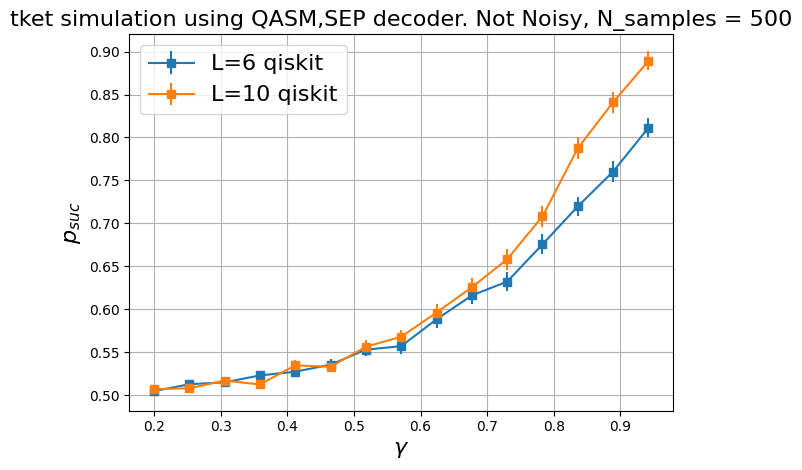

In [49]:
# %matplotlib qt
# pl.figure(1)

# data=load_data('data/emulator_sep_data/seed=1_all_qubits_special_scrambled')
# L_list = [6,8,10,12,14,16][:1]
# # plot_success_ent(data,L_list,charge_fac=0,marker='s')
# plot_success_binder(data,L_list,marker='s',N_samples=50)
# pl.title('SEP decoder. Not Noisy, N_samples = 100',fontsize=16)
# pl.tight_layout()
# # pl.xlim(0.3,0.5)
# # pl.ylim(-2,1)


pl.figure(2)
# pl.ylim(0,np.log(2))
# data=load_data('data/tket_simulation/tket_multiple_ancilla_sep_data/seed=1_all_qubits')
# L_list = [6,8,10,12,14,16][:3][::2]
# # plot_success_ent(data,L_list,charge_fac=0,marker='s')
# plot_success_ent(data,L_list,marker='s',N_samples=-1,label='tket_multiple')
# pl.title('tket simulation using QASM,SEP decoder. Not Noisy, N_samples = 500',fontsize=16)
# pl.tight_layout()
# pl.grid(which='both')
# # pl.xlim(0.3,0.5)
# # pl.ylim(-2,1)

# data=load_data('data/tket_simulation/tket_sep_data/seed=1_all_qubits')
# # L_list = [6,8,10,12,14,16][:1][:]
# # plot_success_ent(data,L_list,charge_fac=0,marker='s')
# plot_success_ent(data,L_list,marker='s',N_samples=-1,label='tket')
# pl.title('tket simulation using QASM,SEP decoder. Not Noisy, N_samples = 500',fontsize=16)
# pl.tight_layout()
# pl.grid(which='both')

# data=load_data('data/qiskit_simulation/qiskit_multiple_ancilla_sep_data/seed=1_all_qubits')
# # L_list = [6,8,10,12,14,16][:1][:]
# # plot_success_ent(data,L_list,charge_fac=0,marker='s')
# plot_success_ent(data,L_list,marker='s',N_samples=-1,label='qiskit_multiple')
# pl.title('tket simulation using QASM,SEP decoder. Not Noisy, N_samples = 500',fontsize=16)
# pl.tight_layout()
# pl.grid(which='both')

data=load_data('data/qiskit_simulation/qiskit_sep_data_constant_depth/seed=1_all_qubits')
# L_list = [6,8,10,12,14,16][:1][:]
# plot_success_ent(data,L_list,charge_fac=0,marker='s')
plot_success_ent(data,L_list,marker='s',N_samples=-1,label='qiskit')
pl.title('tket simulation using QASM,SEP decoder. Not Noisy, N_samples = 500',fontsize=16)
pl.tight_layout()
pl.grid(which='both')
# pl.xlim(0.4,0.8)
# pl.ylim(0,1)

In [134]:
test_q = qk.QuantumCircuit(2)
test_q.x(0)
# test_q.x(1)
test_q.u1(1,0)
# test_q.cnot(0,1)
test_q.rz(3,1)
# test_q.cnot(1,0)
test_p = qiskit_to_tk(test_q)
test_q.save_statevector()
# test_q.measure([0,1],[0,1])
simulator = AerSimulator()
print(simulator.run(test_q,shots=1).result().data())
test_q.draw()

{'statevector': Statevector([0.        +0.j        , 0.87758256-0.47942554j,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2))}


/var/folders/tm/g65yh1_d5f3gkpxmzywryqwc0000gn/T/ipykernel_8171/3886227500.py:4: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  test_q.u1(1,0)


┌───┐  ┌───────┐ statevector 
q_0: ──┤ X ├──┤ U1(1) ├──────░──────
     ┌─┴───┴─┐└───────┘      ░      
q_1: ┤ Rz(3) ├───────────────░──────
     └───────┘               ░

In [135]:
backend = AerStateBackend()
test_p2 = backend.get_compiled_circuit(test_p)
render_circuit_jupyter(test_p2)
handle = backend.process_circuit(test_p2,n_shots=10000)
result = backend.get_result(handle)
print(np.round(result.get_state(),5))

[ 0.     +0.j      -0.     +0.j       0.87758-0.47943j -0.     +0.j     ]
